In [1]:
# To install surprise library
!conda install -c conda-forge scikit-surprise -y

Solving environment: ...working... done

# All requested packages already installed.



In [2]:
import numpy as np
import pandas as pd

from biclustlib.algorithms import *
from biclustlib.models import Bicluster, Biclustering
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import iterable
from typing import List
from collections import defaultdict
import logging

from surprise import KNNBaseline
from surprise import KNNBasic
from surprise import Dataset
from surprise import get_dataset_dir
from surprise import Reader
import pandas as pd
import numpy as np

from sklearn.neighbors import NearestNeighbors
from surprise.model_selection.split import train_test_split
from scipy.sparse import csr_matrix
from surprise.prediction_algorithms.co_clustering import CoClustering
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.prediction_algorithms.knns import KNNBasic

In [3]:
np.random.seed(42)

In [4]:
def enable_logging(enable: bool):
    logging_level = [logging.CRITICAL, logging.DEBUG][int(enable)]
    logging.getLogger(__name__).setLevel(logging_level)

In [5]:
### Set True if you want to use logging, False otherwise ###
logging.basicConfig(format='%(asctime)s: "%(message)s"', datefmt="%H:%M:%S")
enable_logging(False)

### NBCF

In [6]:
def sim(user_items: np.ndarray, bicluster: Bicluster):
    return len(np.intersect1d(user_items.nonzero(), bicluster.cols)) / len(bicluster.cols)

In [7]:
def wf(user_items: np.ndarray, bicluster: Bicluster):
    return sim(user_items, bicluster) * len(bicluster.rows)

In [8]:
def NBCF(user_items: np.ndarray, biclusters: Biclustering):
    results = [[wf(user_items, cluster), cluster] for cluster in biclusters.biclusters]
    results.sort(key=lambda x: -x[0])
    return results

## Recommendations

In [9]:
def recommendation(df: pd.DataFrame, user_items: np.ndarray, biclusters: Biclustering, k_items: int):
    if isinstance(user_items, pd.Series):
        user_items = np.array(user_items)

    items_to_recommend = set()
    neighboring_biclusters = NBCF(user_items, biclusters)
    for i, biclust_to_analyze in neighboring_biclusters:
        item_ratings = []

        users_ratings = df.iloc[biclust_to_analyze.rows, biclust_to_analyze.cols]
        item_ratings = list(zip(np.mean(users_ratings[users_ratings != 0], axis=0), biclust_to_analyze.cols))

        if len(item_ratings) != 0:
            item_ratings.sort(key=lambda x: -x[0])
            items_to_recommend |= {p[1] for p in item_ratings[: k_items]}

        if len(items_to_recommend) >= k_items:
            break

    return list(items_to_recommend)[:k_items]

In [10]:
def binary_recommendation(df: pd.DataFrame, user_items: np.ndarray, biclusters: Biclustering, k_items: int):
    if isinstance(user_items, pd.Series):
        user_items = np.array(user_items)

    items_to_recommend = set()
    neighboring_biclusters = NBCF(user_items, biclusters)
    for _, biclust_to_analyze in neighboring_biclusters:
        items_to_recommend |= set(biclust_to_analyze.cols[: k_items])
        if len(items_to_recommend) >= k_items:
            break

    return list(items_to_recommend)[:k_items]

## Metrics

In [11]:
def precision(prediction: np.ndarray, user_items: np.ndarray, positive_threshold: float) -> float:
    return len(np.intersect1d(np.nonzero(user_items > positive_threshold), prediction)) / len(prediction) if len(prediction) != 0 else 0

In [12]:
def recall(prediction: np.ndarray, user_items: np.ndarray, positive_threshold: float) -> float:
    liked_items = np.nonzero(user_items > positive_threshold)
    return len(np.intersect1d(liked_items, prediction)) / len(liked_items[0]) if len(liked_items[0]) != 0 else 0

In [13]:
def f1_score(precisions: iterable, recalls: list):
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    dividend = 2 * (precisions * recalls)
    divider = precisions + recalls
    return np.divide(dividend, divider, out=np.zeros_like(dividend), where = divider != 0)

In [14]:
def stability(values: list) -> float:
    """
    Calculates the difference between the minimum and maximum value in the list
    :param values: list of values. Precisions, for instance
    :return: number from 0 to 1. 1 = stable, 0 = unstable
    """
    return 1 - (np.max(values) - np.min(values))

In [15]:
def calc_metric(data: pd.DataFrame, sample: pd.DataFrame, biclustering: Biclustering, n_items: int, metric: callable,
                is_binary: bool = False, positive_threshold: float = 3) -> float:
    """
    Return precision or recall (depending on 'metric' parameter) for sample dataframe
    :param data: original df
    :param sample: test df
    :param biclustering: biclusters
    :param n_items: number of recommendations
    :param metric: precision or recall function
    :param is_binary: is data binary or not. Set to True for BiBit algorithm
    :param positive_threshold: threshold for items filtering
    :return: mean of precisions for each user
    """

    recommendation_function = [recommendation, binary_recommendation][is_binary]
    positive_threshold *= not is_binary

    metric_values = [
        metric(
            recommendation_function(
                data,
                sample.iloc[i],
                biclustering,
                n_items
            ),
            np.asarray(sample.iloc[i]),
            positive_threshold
        ) for i in range(len(sample))]
    logging.getLogger(__name__).debug(f"Finish calculating {metric.__name__} for n_items = {n_items}")
    return float(np.mean(metric_values))

In [16]:
def getPrecisionsAndRecalls(
        df: pd.DataFrame, test: pd.DataFrame, y_train: Biclustering,
        positive_threshold: float = 3, make_binary: bool = False, items_count: iterable = np.arange(5, 55, 5)):
    """
    Return array of arrays of precisions and recalls
    :param df: original data
    :param test: test users
    :param y_train: biclustering, that we get from algorithm running
    :param positive_threshold: threshold for 'good items'. 3 by default
    :param make_binary: transform data to binary representation. False by default
    :param items_count: iterable of N-s for top-N recommendations
    :return: list of precisions and recalls
    """
    logging.getLogger(__name__).debug("Biclustering has been finished")
    df_ = df.copy()
    test_ = test.copy()

    if make_binary:
        df_[df_ <= positive_threshold] = 0
        df_[df_ > positive_threshold] = 1
        test_[test_ <= positive_threshold] = 0
        test_[test_ > positive_threshold] = 1

    return [calc_metric(df_, test_, y_train, count, precision, make_binary, positive_threshold) for count in items_count], [
        calc_metric(df_, test_, y_train, count, recall, make_binary, positive_threshold) for count in items_count]

In [17]:
# Surprise method to calculate precision and recall for k-recommendations
def precision_recall_at_k(predictions, k, threshold):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls


def getPrecisionsAndRecallsSurprise(test, y_train, threshold: float, items_count: iterable = np.arange(5, 55, 5)):
    """
    Return precisions and recalls for each top-N
    Parameters
    ----------
    test: surprise testset
    y_train: model
    threshold: positive threshold
    items_count: N-s

    Returns list of precisions and list of recalls
    -------

    """
    predictions = y_train.test(test)
    ps = [] # precisions
    rs = [] # recalls
    for i in items_count:
        # CHANGE THRESHOLD FOR ML-100k OR JESTER. 0-threshold use for original Jester dataset (values from -10 to 10)
        precisions, recalls = precision_recall_at_k(predictions, k=i, threshold=threshold)
        ps.append(np.mean(list(precisions.values())))
        rs.append(np.mean(list(recalls.values())))
    return ps, rs

## Datasets

In [18]:
def _ml_100k_preprocessing(to_preprocess_df: pd.DataFrame):
    return to_preprocess_df.fillna(0)


def _jester_100k_preprocessing(to_preprocess_df: pd.DataFrame):
    preproc_jester = to_preprocess_df.copy()
    preproc_jester += 11
    return preproc_jester.round().fillna(0).astype(int)


def load_dataset(name: str, preprocessing: bool = True, default_datasets_folder: str = "datasets"):
    available_datasets = ["ml-100k", "jester"] # TODO kill this hardcode

    preprocessing_funcs = {
        "ml-100k" : _ml_100k_preprocessing,
        "jester" : _jester_100k_preprocessing
    }

    name = name.lower().strip()

    if name == "ml-100k":
        dataset_dir = f"{default_datasets_folder}/ml"

        r_cols = ["userId", "movieId", "rating", "unix_timestamp"]
        ratings = pd.read_csv(f"{dataset_dir}/u.data", sep='\t', names=r_cols, encoding="latin-1")

        m_cols = ['movieId', 'title', 'release_date', 'video_release_date', 'imdb_url']
        movies = pd.read_csv(f"{dataset_dir}/u.item", sep='|', names=m_cols, usecols=range(5), encoding="latin-1")

        # Drop useless features
        ratings = ratings.drop(["unix_timestamp"], axis=1)
        movies = movies.drop(["release_date", "video_release_date", "imdb_url"], axis=1)

        total = pd.merge(ratings, movies, on="movieId")

        # Complete dataset matrix
        _ml_100k_df = pd.pivot_table(data=total, index="userId", columns="title", values="rating")
        return preprocessing_funcs[name](_ml_100k_df) if preprocessing else _ml_100k_df
    elif name == "jester":
        original_jester_df = pd.read_excel(f"{default_datasets_folder}/jester/jester-data-1.xls", names=range(1, 101), header=None, na_values=99).reset_index(drop=True)
        return preprocessing_funcs[name](original_jester_df) if preprocessing else original_jester_df
    else:
        raise ValueError(f"Unknown dataset '{name}'. Available datasets: {', '.join(available_datasets)}")

In [19]:
def make_binary(df: pd.DataFrame, threshold: float):
    to_binarize = df.copy()
    to_binarize[to_binarize <= threshold] = 0
    to_binarize[to_binarize > threshold] = 1
    return to_binarize

In [20]:
def surprise_suiting(user_item_table: pd.DataFrame) -> pd.DataFrame:
    """Transform user/item matrix into surprise-library representation"""
    d = np.array(user_item_table)
    res = [(row, index, d[row, index]) for row in range(d.shape[0]) for index in range(d.shape[1]) if d[row, index] != 0]

    return pd.DataFrame(res, columns=["user_id", "item_id", "rating"])


def to_surprise_dataset(df: pd.DataFrame, rating_scale: tuple):
    """Transform dataset to surprise Dataset object"""
    df_cp = surprise_suiting(df.copy()).dropna()
    return Dataset.load_from_df(df_cp, Reader(rating_scale=rating_scale))

In [21]:
ml_df = load_dataset("ml-100k")
ml_df

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,2.0,5.0,0.0,0.0,3.0,4.0,0.0,0.0,...,0.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,2.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
jester_df = load_dataset("jester")
jester_df

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,3,20,1,3,3,2,1,15,2,6,...,14,0,0,0,0,0,5,0,0,0
1,15,11,17,15,9,1,10,6,20,20,...,14,6,11,19,11,9,14,11,7,12
2,0,0,0,0,20,20,20,20,0,0,...,0,0,0,20,0,0,0,0,0,0
3,0,19,0,0,13,19,8,17,0,13,...,0,0,0,12,0,0,0,0,0,0
4,20,16,7,6,12,13,18,16,11,17,...,16,17,15,16,17,13,14,18,13,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24978,11,18,20,13,14,18,2,10,2,18,...,20,10,20,4,19,20,18,20,20,18
24979,20,3,20,20,12,2,8,17,3,16,...,10,5,10,11,20,3,4,2,20,19
24980,0,0,0,0,3,0,18,4,0,0,...,0,0,0,0,0,0,0,0,0,0
24981,0,0,0,0,1,0,16,3,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# Without preprocessing
original_jester_df = load_dataset("jester", preprocessing=False)
original_jester_df

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,...,2.82,NaN,NaN,NaN,NaN,NaN,-5.63,NaN,NaN,NaN
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,...,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,NaN,NaN,NaN,NaN,9.03,9.27,9.03,9.27,NaN,NaN,...,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,8.35,NaN,NaN,1.80,8.16,-2.82,6.21,NaN,1.84,...,NaN,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN,NaN
4,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,...,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24978,0.44,7.43,9.08,2.33,3.20,6.75,-8.79,-0.53,-8.74,7.23,...,8.83,-1.21,9.22,-6.70,8.45,9.03,6.55,8.69,8.79,7.43
24979,9.13,-8.16,8.59,9.08,0.87,-8.93,-3.50,5.78,-8.11,4.90,...,-1.17,-5.73,-1.46,0.24,9.22,-8.20,-7.23,-8.59,9.13,8.45
24980,NaN,NaN,NaN,NaN,-7.77,NaN,6.70,-6.75,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24981,NaN,NaN,NaN,NaN,-9.71,NaN,4.56,-8.30,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
def normalize(df_to_normalize: pd.DataFrame):
    return df_to_normalize[df_to_normalize != 0].sub(df_to_normalize[df_to_normalize != 0].mean(axis=1), axis=0).fillna(0)

## Some dataset information

In [25]:
def density(df: pd.DataFrame):
    return (df > 0).values.sum() / (df.shape[0] * df.shape[1])


print(f"ML100k density = {round(density(ml_df), 3)}")
print(f"Jester density = {round(density(jester_df), 3)}")

ML100k density = 0.064
Jester density = 0.725


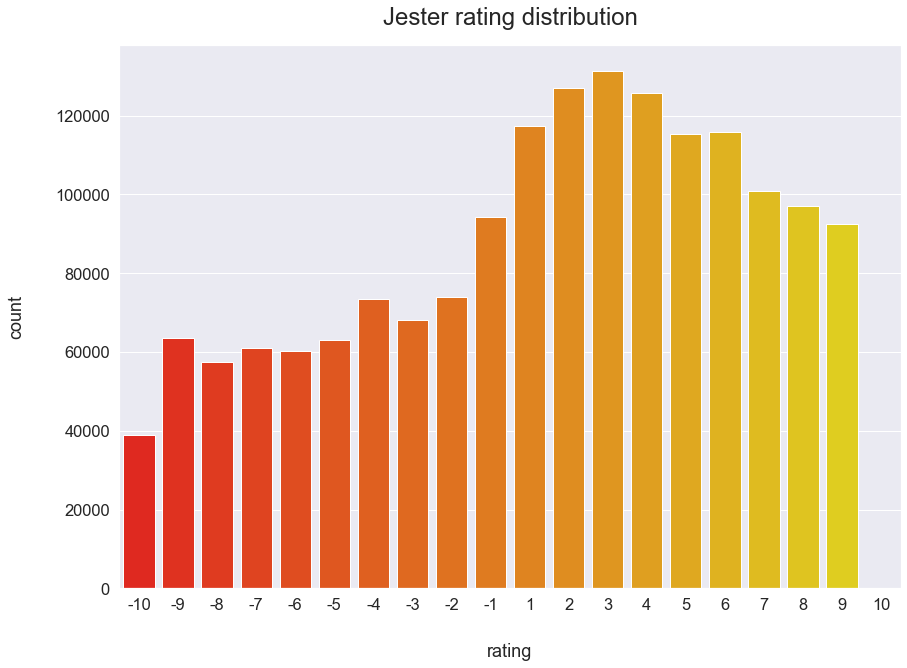

In [26]:
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['axes.labelpad'] = 30
sns.set(font_scale=1.5)
plt.title("Jester rating distribution", pad=20, fontsize=24)

p = sns.countplot(x=surprise_suiting(original_jester_df.round().fillna(0)).rating.astype(int), palette="autumn")

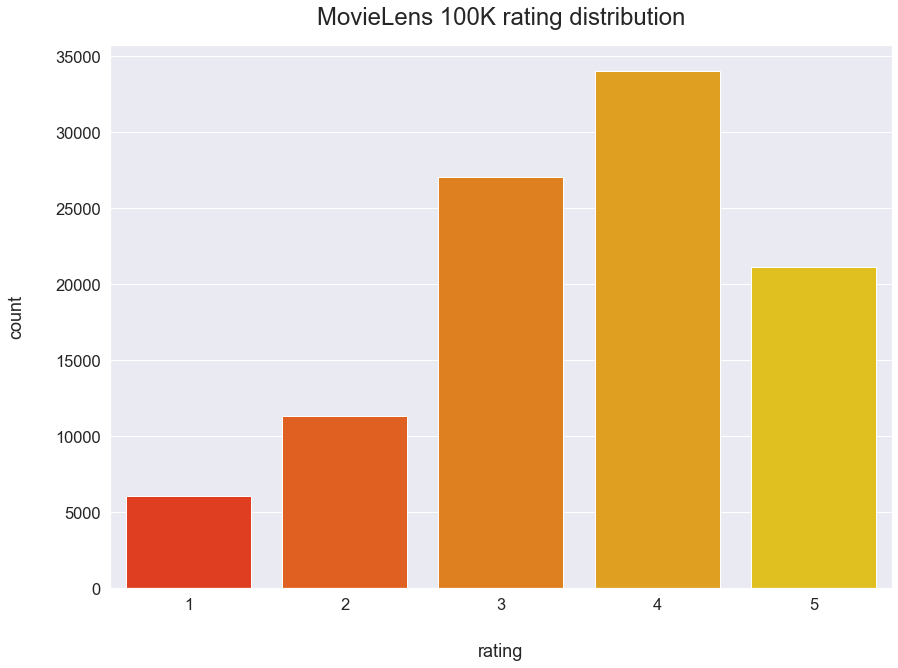

In [27]:
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['axes.labelpad'] = 30
sns.set(font_scale=1.5)
plt.title("MovieLens 100K rating distribution", pad=20, fontsize=24)

_ = sns.countplot(x=surprise_suiting(ml_df).rating.astype(int), palette="autumn")

## Biclusters functions

In [28]:
def biclusters_quality(biclusters: Biclustering):
    """
    Calculates the quality of the biclusters: the percentage of biclusters overlapping
    :param biclusters: biclustering object
    :return: number from 0 to 1. Zero indicates perfect biclusters, while one indicates a full overlapping
    """
    similarity = [cluster.overlap(another) for i, cluster in enumerate(biclusters.biclusters) for another in biclusters.biclusters[i + 1:]]
    return np.mean(similarity) if similarity else 0

In [29]:
def find_best_biclusters(user: pd.Series, biclustering: Biclustering, sort_by: str = "WF"):
    """
    Return information about the best biclusters for current user: bicluster number - number of appropriate items - weighed frequency
    :param user: user to analyse
    :param biclustering: list of biclusters
    :param sort_by: name of the column relative to which we sort dataframe
    :return: dataframe
    """
    info = []
    for i, bicluster in enumerate(biclustering.biclusters):
        info.append((i, user[bicluster.cols].sum(), wf(np.array(user), bicluster)))

    info.sort(key=lambda x: -x[1])
    d = pd.DataFrame(info, columns=["Bicluster №", "Good Items", "WF"])
    d["WF"] = round(d["WF"], 2)
    d["Good Items"] = d["Good Items"].astype(int)
    return d.sort_values(sort_by, ascending=False)

In [30]:
def bicluster_average(sample: pd.DataFrame, bicluster: Bicluster):
    """Calculate average value in bicluster, excluding missing values"""
    t = sample.iloc[bicluster.rows, bicluster.cols]
    if (t > 0).sum().sum() < 1e-6:
        return 0
    return t[t > 0].sum().sum() / (t > 0).sum().sum()

In [31]:
def biclustering_statictics(precisions: list, recalls: list, algo_names: List[str]):
    stabilities = [np.round(stability(precisions), 2) for precisions in precisions]
    precision_means = [np.round(np.mean(precisions), 2) for precisions in precisions]
    recalls_means = [np.round(np.mean(recalls), 2) for recalls in recalls]
    f1_score_means = [np.round(np.mean(f1_score(precisions, recalls)), 2) for precisions, recalls in zip(precisions, recalls)]

    return pd.DataFrame([stabilities, precision_means, recalls_means, f1_score_means], columns=algo_names, index=["Stability", "Average precision", "Average recall", "Average F1 score"])

In [32]:
def user_coverage(df_train: pd.DataFrame, biclustering: Biclustering):
    rows = set()
    for bicluster in biclustering.biclusters:
        rows.update(bicluster.rows)
    return len(rows) / len(df_train)


def item_coverage(df_train: pd.DataFrame, biclustering: Biclustering):
    rows = set()
    for bicluster in biclustering.biclusters:
        rows.update(bicluster.cols)
    return len(rows) / df_train.shape[1]


def coveragies(df_train: pd.DataFrame, y_trains: list, algo_names: list):
    uc_all = [round(user_coverage(df_train, y_train_cur) * 100, 1) for y_train_cur in y_trains]
    ic_all = [round(item_coverage(df_train, y_train_cur) * 100, 1) for y_train_cur in y_trains]
    return pd.DataFrame(data=[uc_all, ic_all, (np.array(uc_all) + np.array(ic_all)) / 2],
                        columns=algo_names, index=["User Coverage (%)", "Item Coverage (%)", "Mean Coverage (%)"])

## Naive KNN Biclustering

In [33]:
class NaiveKNNBiclustering:
    def __init__(self, positive_threshold: float, user_n_clusters: int = 5, item_n_clusters: int = 5):
        self.threshold = positive_threshold
        self.user_n_clusters = user_n_clusters
        self.item_n_clusters = item_n_clusters


    def run(self, train: pd.DataFrame):
        from sklearn.cluster import KMeans # KNN clustering

        # Users clustering
        model_users = KMeans(self.user_n_clusters)
        model_users.fit(train)
        labels_users = pd.Series(model_users.labels_)

        # Items clustering
        model_items = KMeans(self.user_n_clusters)
        model_items.fit(train.T)
        labels_items = pd.Series(model_items.labels_)

        # Transform into list of rows and then create Biclustering
        rows_clusters = [list(labels_users[labels_users == i].index) for i in range(self.user_n_clusters)]
        cols_clusters = [list(labels_items[labels_items == i].index) for i in range(self.user_n_clusters)]

        y_train_test_knn = Biclustering([Bicluster(row, col) for row in rows_clusters for col in cols_clusters])
        len(y_train_test_knn.biclusters)

        # Remove 'bad' biclusters with average value less than positive threshold
        return Biclustering([bicl for bicl in y_train_test_knn.biclusters if bicluster_average(train, bicl) > self.threshold])

## Spectral Coclustering Wrapper

In [34]:
from sklearn.cluster import SpectralCoclustering


class SpectralCoclusteringWrapper(SpectralCoclustering):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)


    def run(self, train, add_one_to_df: bool = True) -> Biclustering:
        train_cp = train.copy()
        if add_one_to_df:
            train_cp += 1

        clustering = self.fit(train_cp)
        biclusters = [Bicluster(index[0], index[1]) for index in
                      [clustering.get_indices(i) for i in range(clustering.n_clusters)]]
        y_train_spectral = Biclustering(biclusters)

        # Delete empty biclusters
        y_train_spectral.biclusters = [bicl for bicl in y_train_spectral.biclusters if len(bicl.rows) != 0 and len(bicl.cols) != 0]
        return y_train_spectral

# Graphs

In [35]:
# Array of recommendations numbers
items_count = np.arange(5, 55, 5)


def plot_metric_N_recom(metric_name: str, dataset_name: str, metric_values: List[list], algo_names: List[str], legend_loc: str = "upper right"):
    # Matplotlib settings
    plt.rcParams['figure.figsize'] = (15, 11)
    plt.rcParams['axes.labelpad'] = 30
    sns.set(font_scale=1.5)
    plt.ylim(0, 1)
    sns.set_theme(style="white")
    plt.xlabel("N recommendations")
    plt.ylabel(metric_name)
    plt.title(dataset_name, pad=20, fontsize=24)

    # Plotting
    prec = pd.DataFrame(metric_values, index=algo_names, columns=items_count)
    _ = sns.lineplot(data=prec.T, linewidth=4, dashes=False)
    l = plt.legend(fontsize=14, loc=legend_loc)
    for handler in l.legendHandles:
        handler.set_linewidth(5)

## Movielens

In [36]:
# Split by train and test
ml_train = ml_df.iloc[:700]
ml_test = ml_df.iloc[700:]

In [37]:
%%time
# Plaid
ml_precisions_plaid, ml_recalls_plaid = getPrecisionsAndRecalls(ml_df, ml_test, ml_y_train_plaid := Plaid(30, True, 0.05, 0.05).run(ml_train), positive_threshold=3)

CPU times: total: 1min 37s
Wall time: 27.4 s


In [38]:
%%time
# LargeAverageSubmatrices
ml_precisions_las, ml_recalls_las = getPrecisionsAndRecalls(ml_df, ml_test, ml_y_train_las := LargeAverageSubmatrices(30, 0.8, 100).run(ml_train))

CPU times: total: 2min 14s
Wall time: 2min 14s


In [39]:
%%time
# Cheng
ml_precisions_cheng, ml_recalls_cheng = getPrecisionsAndRecalls(ml_df, ml_test, ml_y_train_cheng := ChengChurchAlgorithm(30, data_min_cols=20).run(ml_train))

CPU times: total: 8min 3s
Wall time: 8min 3s


In [40]:
%%time
# BitPatternBiclusteringAlgorithm 365 biclusters
ml_precisions_bibit, ml_recalls_bibit = getPrecisionsAndRecalls(ml_df, ml_test, ml_y_train_bibit := BitPatternBiclusteringAlgorithm(10, 10).run(make_binary(ml_train, 3)), positive_threshold=3, make_binary=True)

CPU times: total: 1min 8s
Wall time: 1min 8s


In [41]:
len(ml_y_train_bibit.biclusters)

365

In [42]:
%%time
ml_precisions_spectral, ml_recalls_spectral = getPrecisionsAndRecalls(ml_df, ml_test, ml_y_train_spectral := SpectralCoclusteringWrapper(n_clusters=30, random_state=0).run(ml_train))

CPU times: total: 20.5 s
Wall time: 15.7 s


In [43]:
%%time
# RANDOM
ml_precisions_random, ml_recalls_random = [], []
for c in items_count:
    ml_precisions_random.append(np.array([precision(np.random.choice(range(ml_test.shape[1]), c), np.array(ml_test.iloc[i]), 3) for i in range(len(ml_test))]).mean())
    ml_recalls_random.append(np.array([recall(np.random.choice(range(ml_test.shape[1]), c), np.array(ml_test.iloc[i]), 3) for i in range(len(ml_test))]).mean())

CPU times: total: 1.27 s
Wall time: 1.28 s


In [44]:
%%time
# Naive KNN Biclustering
ml_precisions_naive_knn, ml_recalls_naive_knn = getPrecisionsAndRecalls(ml_df, ml_test, ml_y_train_naive_knn := NaiveKNNBiclustering(3.5, 30, 30).run(ml_train), positive_threshold=3, items_count=items_count)

CPU times: total: 4min 53s
Wall time: 4min 43s


In [155]:
ml_trainset, ml_testset = train_test_split(to_surprise_dataset(ml_df, (1, 5)), test_size=0.3, shuffle=False)

In [156]:
%%time
# Coclust
ml_precisions_coclust, ml_recalls_coclust = getPrecisionsAndRecallsSurprise(ml_testset, ml_y_train_coclust := CoClustering(n_cltr_u=20, n_cltr_i=20).fit(ml_trainset), threshold=3.5)

<timed exec>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


CPU times: total: 5.62 s
Wall time: 6 s


In [157]:
%%time
# SVD
ml_precisions_svd, ml_recalls_svd = getPrecisionsAndRecallsSurprise(ml_testset, ml_y_train_svd := SVD().fit(ml_trainset), threshold=3.5)

CPU times: total: 3.42 s
Wall time: 3.54 s


In [158]:
%%time
# UBKNN
ml_precisions_ubknn, ml_recalls_ubknn = getPrecisionsAndRecallsSurprise(ml_testset, ml_y_train_ubknn := KNNBasic(sim_options = {'name': 'cosine', 'user_based': True}).fit(ml_trainset), threshold=3.5)

Computing the cosine similarity matrix...
Done computing similarity matrix.
CPU times: total: 1.53 s
Wall time: 1.58 s


In [159]:
ml_y_train_ubknn.test(ml_testset)

[Prediction(uid=641, iid=145, r_ui=4.0, est=3.1622786269331336, details={'actual_k': 37, 'was_impossible': False}),
 Prediction(uid=641, iid=146, r_ui=3.0, est=3.493797278953149, details={'actual_k': 33, 'was_impossible': False}),
 Prediction(uid=641, iid=159, r_ui=4.0, est=2.2178554092767087, details={'actual_k': 14, 'was_impossible': False}),
 Prediction(uid=641, iid=169, r_ui=2.0, est=2.5431755425995, details={'actual_k': 10, 'was_impossible': False}),
 Prediction(uid=641, iid=175, r_ui=3.0, est=3.2044021209771683, details={'actual_k': 29, 'was_impossible': False}),
 Prediction(uid=641, iid=176, r_ui=4.0, est=1.7192021848653107, details={'actual_k': 24, 'was_impossible': False}),
 Prediction(uid=641, iid=179, r_ui=2.0, est=3.7509887516685976, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=641, iid=183, r_ui=2.0, est=2.4731885158607945, details={'actual_k': 39, 'was_impossible': False}),
 Prediction(uid=641, iid=184, r_ui=2.0, est=4.3987592728043765, details={'ac

In [160]:
ml_all_precisions = [
    ml_precisions_plaid,
    ml_precisions_las,
    ml_precisions_cheng,
    ml_precisions_bibit,
    ml_precisions_spectral,
    ml_precisions_coclust,
    ml_precisions_ubknn,
    ml_precisions_svd,
    ml_precisions_random,
    # ml_precisions_naive_knn
]

ml_all_recalls = [
    ml_recalls_plaid,
    ml_recalls_las,
    ml_recalls_cheng,
    ml_recalls_bibit,
    ml_recalls_spectral,
    ml_recalls_coclust,
    ml_recalls_ubknn,
    ml_recalls_svd,
    ml_recalls_random,
    # ml_recalls_naive_knn
]

ml_all_algo_names = [
    "Plaid",
    "LAS",
    "Cheng & Church",
    "BiBit",
    "Spectral Coclustering",
    "COCLUST",
    "UBKNN",
    "SVD",
    "Random",
    # "Naive KNN Biclustering"
]

### Movielens precision

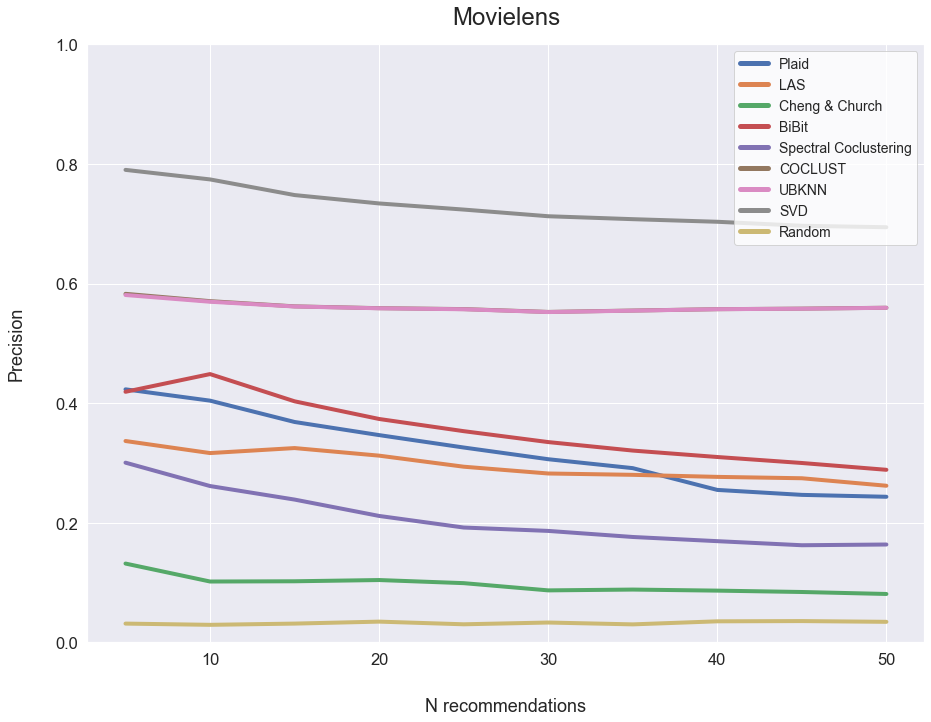

In [161]:
# PRECISION
plot_metric_N_recom("Precision", "Movielens", ml_all_precisions, ml_all_algo_names)

### Movielens recall

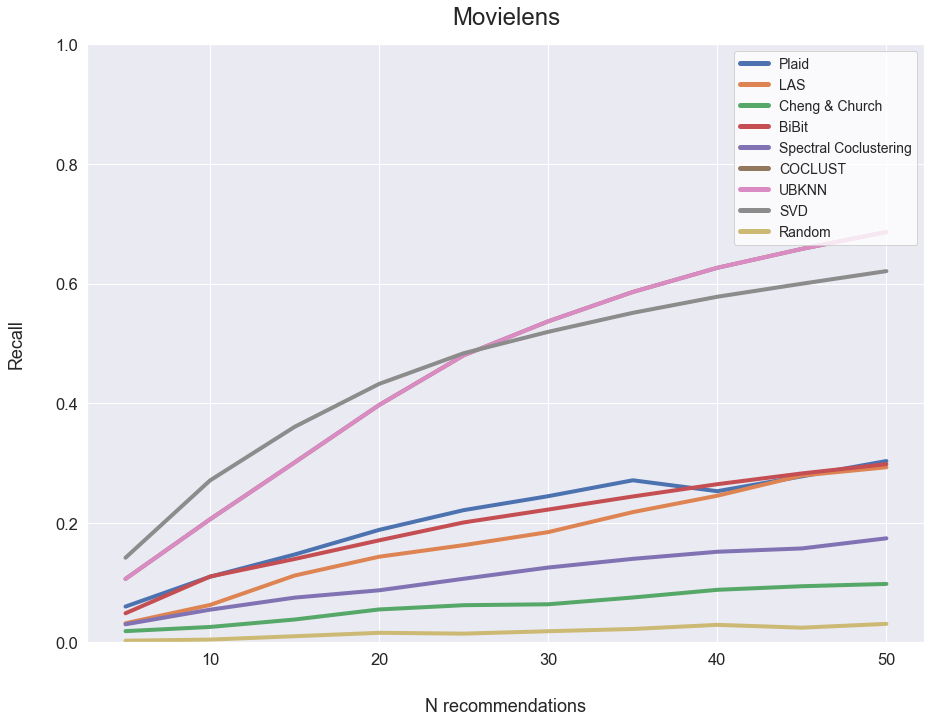

In [162]:
# RECALL
plot_metric_N_recom("Recall", "Movielens", ml_all_recalls, ml_all_algo_names)

### Movielens f1 score

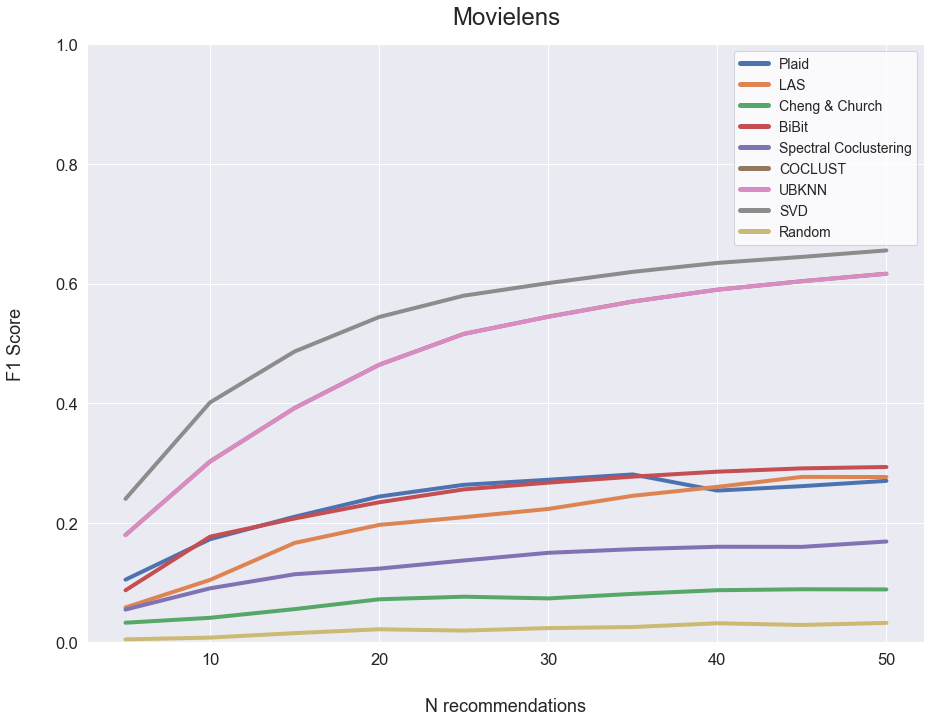

In [163]:
# F1 SCORE
plot_metric_N_recom("F1 Score", "Movielens", f1_score(ml_all_precisions, ml_all_recalls), ml_all_algo_names)

### Movielens metrics summary

In [164]:
# Statistics
precisions_lst = [ml_precisions_plaid, ml_precisions_cheng, ml_precisions_las, ml_precisions_bibit, ml_precisions_spectral, ml_precisions_ubknn, ml_precisions_svd, ml_precisions_random]
recalls_lst = [ml_recalls_plaid, ml_recalls_cheng, ml_recalls_las, ml_recalls_bibit, ml_recalls_spectral, ml_recalls_ubknn, ml_recalls_svd, ml_recalls_random]
names = ["Plaid", "Cheng & Church", "LAS", "BiBit", "Spectral Coclustering", "UBKNN", "SVD", "Random"]

biclustering_statictics(ml_all_precisions, ml_all_recalls, ml_all_algo_names)

,Plaid,LAS,Cheng & Church,BiBit,Spectral Coclustering,COCLUST,UBKNN,SVD,Random
Stability,0.82,0.93,0.95,0.84,0.86,0.97,0.97,0.90,0.99
Average precision,0.32,0.30,0.10,0.36,0.21,0.56,0.56,0.73,0.03
Average recall,0.21,0.17,0.06,0.20,0.11,0.46,0.46,0.46,0.02
Average F1 score,0.23,0.20,0.07,0.24,0.13,0.48,0.48,0.54,0.02


--------

## Jester

In [54]:
# Train and test
jester_train = jester_df.iloc[:3000]
jester_test = jester_df.iloc[3000:4000]
items_count = np.arange(5, 55, 5)

In [55]:
%%time
# Plaid
jester_precisions_plaid, jester_recalls_plaid = getPrecisionsAndRecalls(jester_df, jester_test, jester_y_train_plaid := Plaid(30, True, 0.03, 0.03).run(jester_train), positive_threshold=10, items_count=items_count)

CPU times: total: 5min 21s
Wall time: 4min 32s


In [56]:
%%time
# Cheng
jester_precisions_cheng, jester_recalls_cheng = getPrecisionsAndRecalls(jester_df, jester_test, jester_y_train_cheng := ChengChurchAlgorithm(50, data_min_cols=20).run(jester_train), positive_threshold=10, items_count=items_count)

CPU times: total: 5min 38s
Wall time: 5min 39s


In [57]:
%%time
# LargeAverageSubmatrices
jester_precisions_las, jester_recalls_las = getPrecisionsAndRecalls(jester_df, jester_test, jester_y_train_las := LargeAverageSubmatrices(30, 0.8, 100).run(jester_train), positive_threshold=10, items_count=items_count)

CPU times: total: 2min 37s
Wall time: 2min 37s


In [58]:
%%time
# BitPatternBiclusteringAlgorithm: 136 biclusters for arguments (30, 20)
jester_precisions_bibit, jester_recalls_bibit = getPrecisionsAndRecalls(jester_df, jester_test[:150], jester_y_train_bibit := BitPatternBiclusteringAlgorithm(30, 20).run(make_binary(jester_train[:400], 10)), positive_threshold=10, make_binary=True, items_count=items_count)

CPU times: total: 9.52 s
Wall time: 9.51 s


In [59]:
len(jester_y_train_bibit.biclusters)

136

In [60]:
%%time
# SpectralCoclustering
jester_precisions_spectral, jester_recalls_spectral = getPrecisionsAndRecalls(jester_df, jester_test, jester_y_train_spectral := SpectralCoclusteringWrapper(n_clusters=30, random_state=0).run(jester_train), positive_threshold=10, items_count=items_count)

CPU times: total: 3min 27s
Wall time: 3min 20s


In [61]:
%%time
# Naive KNN Biclustering
jester_precisions_naive_knn, jester_recalls_naive_knn = getPrecisionsAndRecalls(jester_df, jester_test, jester_y_train_naive_knn := NaiveKNNBiclustering(10, 30, 30).run(jester_train), positive_threshold=10, items_count=items_count)

CPU times: total: 11min 50s
Wall time: 11min 42s


In [165]:
jester_trainset, jester_testset = train_test_split(to_surprise_dataset(original_jester_df[:4000], (-10, 10)), test_size=0.25, shuffle=False)

In [166]:
%%time
# Coclust
jester_precisions_coclust, jester_recalls_coclust = getPrecisionsAndRecallsSurprise(jester_testset, jester_y_train_coclust := CoClustering(n_cltr_u=30, n_cltr_i=30).fit(jester_trainset), threshold=0)

<timed exec>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


CPU times: total: 25.6 s
Wall time: 25.9 s


In [167]:
%%time
# SVD
jester_precisions_svd, jester_recalls_svd = getPrecisionsAndRecallsSurprise(jester_testset, jester_y_train_svd := SVD().fit(jester_trainset), threshold=0)

CPU times: total: 9.69 s
Wall time: 9.71 s


In [168]:
%%time
# UBKNN
jester_precisions_ubknn, jester_recalls_ubknn = getPrecisionsAndRecallsSurprise(jester_testset, jester_y_train_ubknn := KNNBasic(sim_options={'name': 'cosine', 'user_based': False}).fit(jester_trainset), threshold=0)

Computing the cosine similarity matrix...
Done computing similarity matrix.
CPU times: total: 3.3 s
Wall time: 3.33 s


In [79]:
%%time
# RANDOM
jester_precisions_random, jester_recalls_random = [], []
for c in items_count:
    jester_precisions_random.append(np.array([precision(np.random.choice(range(jester_test.shape[1]), c), np.array(jester_test.iloc[i]), 3) for i in range(len(jester_test))]).mean())
    jester_recalls_random.append(np.array([recall(np.random.choice(range(jester_test.shape[1]), c), np.array(jester_test.iloc[i]), 3) for i in range(len(jester_test))]).mean())

CPU times: total: 2.84 s
Wall time: 2.83 s


In [169]:
# TODO coclust
jester_all_precisions = [
    jester_precisions_plaid,
    jester_precisions_las,
    jester_precisions_cheng,
    jester_precisions_bibit,
    jester_precisions_spectral,
    jester_precisions_coclust,
    jester_precisions_ubknn,
    jester_precisions_svd,
    jester_precisions_random,
    # jester_precisions_naive_knn
]

jester_all_recalls = [
    jester_recalls_plaid,
    jester_recalls_las,
    jester_recalls_cheng,
    jester_recalls_bibit,
    jester_recalls_spectral,
    jester_recalls_coclust,
    jester_recalls_ubknn,
    jester_recalls_svd,
    jester_recalls_random,
    # jester_recalls_naive_knn
]

jester_all_algo_names = [
    "Plaid",
    "LAS",
    "Cheng & Church",
    "BiBit",
    "Spectral Coclustering",
    "COCLUST",
    "UBKNN",
    "SVD",
    "Random",
    # "Naive KNN Biclustering"
]

### Jester precision

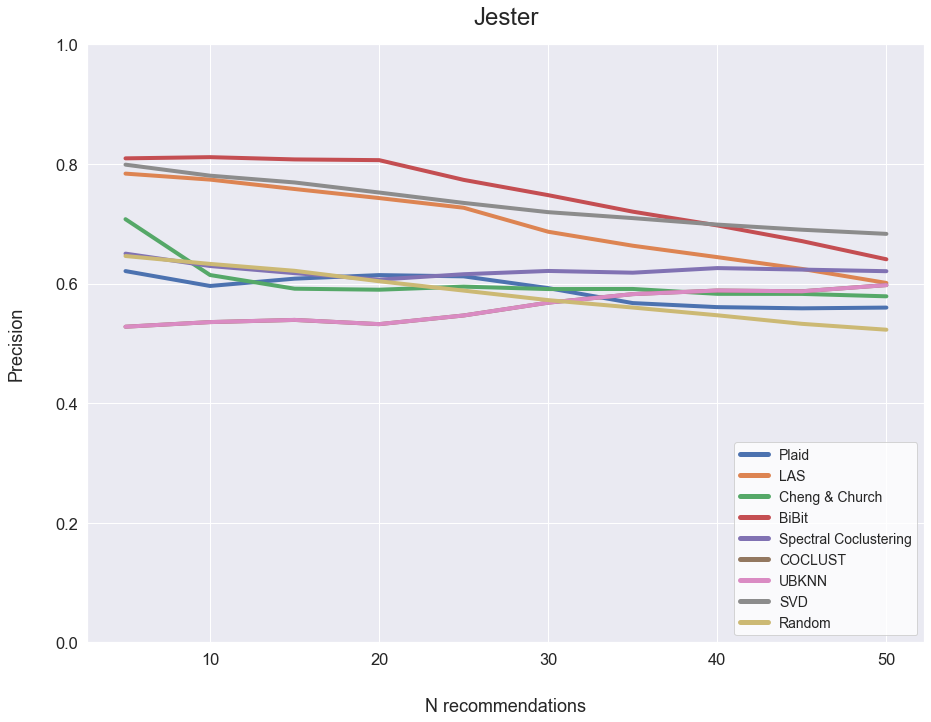

In [170]:
plot_metric_N_recom("Precision", "Jester", jester_all_precisions, jester_all_algo_names, legend_loc="lower right")

### Jester recall

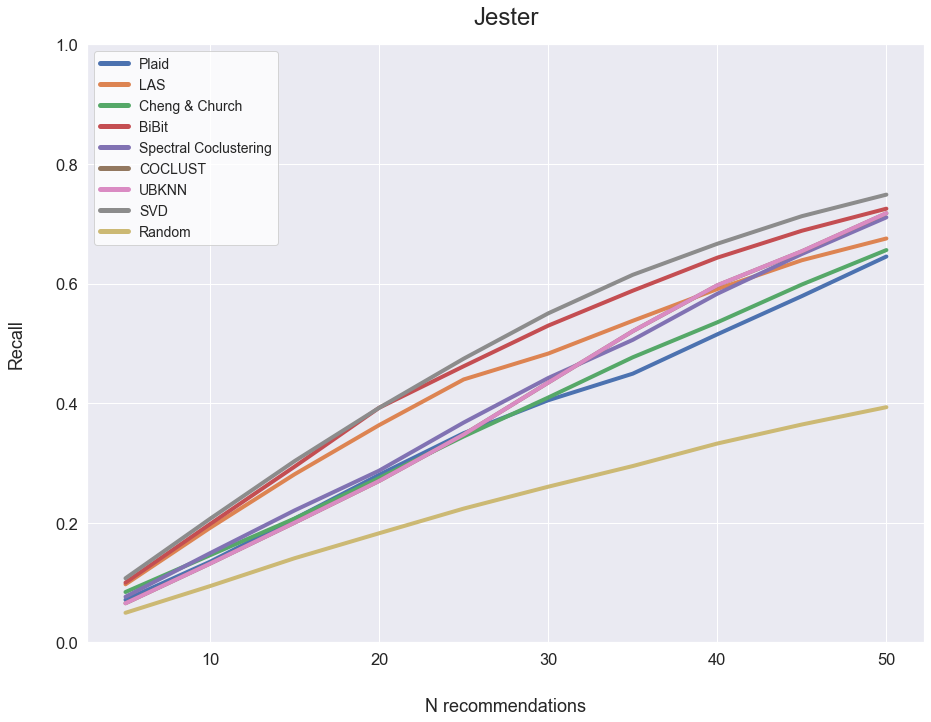

In [171]:
plot_metric_N_recom("Recall", "Jester", jester_all_recalls, jester_all_algo_names, legend_loc="upper left")

### Jester f1 score

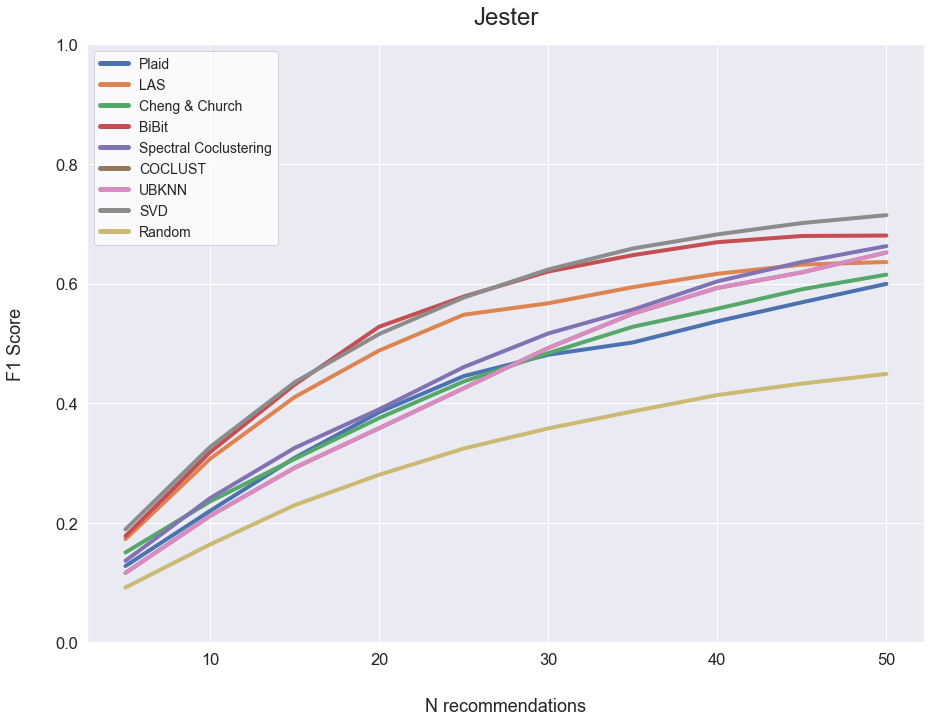

In [172]:
plot_metric_N_recom("F1 Score", "Jester", f1_score(jester_all_precisions, jester_all_recalls), jester_all_algo_names, legend_loc="upper left")

### Jester metrics summary

In [173]:
# Statistics
biclustering_statictics(jester_all_precisions, jester_all_recalls, jester_all_algo_names)

,Plaid,LAS,Cheng & Church,BiBit,Spectral Coclustering,COCLUST,UBKNN,SVD,Random
Stability,0.94,0.82,0.87,0.83,0.96,0.93,0.93,0.88,0.88
Average precision,0.59,0.70,0.60,0.75,0.62,0.56,0.56,0.73,0.58
Average recall,0.36,0.43,0.37,0.46,0.40,0.39,0.39,0.48,0.23
Average F1 score,0.42,0.50,0.43,0.53,0.45,0.43,0.43,0.54,0.31


In [174]:
# User/item coveragies
cs = coveragies(jester_train, [jester_y_train_plaid, jester_y_train_cheng, jester_y_train_las, jester_y_train_bibit, jester_y_train_spectral], ["Plaid", "Cheng & Church", "LAS", "BiBit", "Spectral Coclust"])
cs["BiBit"] = coveragies(jester_train[:400], [jester_y_train_bibit], ["Bibit"])
cs

,Plaid,Cheng & Church,LAS,BiBit,Spectral Coclust
User Coverage (%),100.0,100.0,51.10,45.50,82.50
Item Coverage (%),100.0,79.0,100.00,55.00,100.00
Mean Coverage (%),100.0,89.5,75.55,50.25,91.25


In [99]:
# Biclusters overlapping
pd.DataFrame([round(biclusters_quality(bicl) * 100, 1) for bicl in [jester_y_train_plaid, jester_y_train_cheng, jester_y_train_las, jester_y_train_bibit, jester_y_train_spectral]], index= ["Plaid", "Cheng & Church", "LAS", "BiBit", "Spectral"], columns=["Biclusters Overlapping"])

,Biclusters Overlapping
Plaid,5.2
Cheng & Church,0.3
LAS,11.7
BiBit,40.9
Spectral,0.0
